In [1]:
import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import ihop.community2vec
import ihop.import_data

In [2]:
spark = ihop.utils.get_spark_session("Community2vec Notebook", driver_mem="8G")

22/01/11 19:05:48 WARN Utils: Your hostname, Kurt resolves to a loopback address: 127.0.1.1; using 192.168.0.11 instead (on interface wlp4s0)
22/01/11 19:05:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/11 19:05:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark configuration:
[('spark.executor.id', 'driver'), ('spark.driver.memory', '8G'), ('spark.driver.host', '192.168.0.11'), ('spark.app.id', 'local-1641945950440'), ('spark.sql.warehouse.dir', 'file:/home/virginia/Documents/CenterForDataScience/ZuckermanProj/IHOP/notebooks/spark-warehouse'), ('spark.driver.port', '35835'), ('spark.app.name', 'Community2vec Notebook'), ('spark.app.startTime', '1641945948927'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.executor.extraLibraryPath', '/home/virginia/hadoop-3.3.1/lib/native'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.extraLibraryPath', '/home/virginia/hadoop-3.3.1/lib/native')]


In [3]:
dataroot = "../data/community2vec/RC_2021-06"
subreddit_counts_csv = os.path.join(dataroot, "subreddit_counts.csv")
user_context_path = os.path.join(dataroot, "user_contexts")
vector_save_path = os.path.join(dataroot, "01112022_c2v_vectors")

In [4]:
vocab = ihop.community2vec.get_vocabulary(subreddit_counts_csv)
print("VOCAB SIZE:", len(vocab))
print("VOCAB SNIPPET:")
for i, (k,v) in enumerate(vocab.items()):
    print(k,":",v)
    if i>10:
        break

print("TOTAL COMMENT COUNT:", sum(vocab.values()))

VOCAB SIZE: 10000
VOCAB SNIPPET:
AskReddit : 6235881
FreeKarma4U : 3355746
Superstonk : 2653876
memes : 2233307
wallstreetbets : 2186516
nba : 2062580
amcstock : 1709087
soccer : 1609806
teenagers : 1568039
CryptoCurrency : 1295091
AmItheAsshole : 1083268
politics : 1034608
TOTAL COMMENT COUNT: 190094923


# Baseline Community2Vec model

In [5]:
from ihop.community2vec import GensimCommunity2Vec

myc2v = GensimCommunity2Vec.init_with_spark(spark, vocab, user_context_path, epochs=10, alpha=0.05)


In [ ]:
print("CHECK INITIALIZATION")
print("Longest sentence:", myc2v.max_comments)
print("Num sentences:", myc2v.num_users)
print("Random embeddings nearest neighbor:", myc2v.w2v_model.wv.most_similar("AskReddit"))

CHECK INITIALIZATION
Longest sentence: 258
Num sentences: 7231
Random embeddings nearest neighbor: [('ImagesOfThe2010s', 0.26547014713287354), ('confession', 0.2560444176197052), ('circlejerk', 0.25592470169067383), ('FFXV', 0.23708847165107727), ('ImagesOfNetherlands', 0.22937066853046417), ('BannedFromThe_Donald', 0.22841127216815948), ('GundamExVs', 0.22638258337974548), ('neovim', 0.2199598252773285), ('Drugs', 0.21625253558158875), ('Anxiety', 0.21418383717536926)]


In [ ]:
myc2v.train(compute_loss=True)

2022-01-11 19:02:57,849 : INFO : reading directory ../data/community2vec/sample_data/user_contexts/
2022-01-11 19:02:57,850 : INFO : files read into PathLineSentences:../data/community2vec/sample_data/user_contexts/part-00000-0ad8096e-a7b4-4941-8946-0a8c7cb8108d-c000.csv.bz2
2022-01-11 19:02:57,852 : INFO : Word2Vec lifecycle event {'msg': 'training model with 3 workers on 2275 vocabulary and 150 features, using sg=1 hs=0 sample=0 negative=20 window=258 shrink_windows=True', 'datetime': '2022-01-11T19:02:57.852115', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.0-92-generic-x86_64-with-glibc2.17', 'event': 'train'}
2022-01-11 19:02:57,856 : INFO : reading file ../data/community2vec/sample_data/user_contexts/part-00000-0ad8096e-a7b4-4941-8946-0a8c7cb8108d-c000.csv.bz2
2022-01-11 19:02:57,906 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-01-11 19:02:57,909 : INFO : worker thread finished; awaiting fi

(92210, 92210)

In [ ]:
myc2v.w2v_model.get_latest_training_loss()

207910.984375

In [ ]:
myc2v.w2v_model.wv.most_similar("AskReddit", topn=10)

[('aww', 0.9691705703735352),
 ('Showerthoughts', 0.9533596038818359),
 ('antimatterindustries', 0.9525412321090698),
 ('Conting', 0.9522004723548889),
 ('deadcounting', 0.9518969655036926),
 ('nottheonion', 0.9517742395401001),
 ('counting_in_the_wild', 0.9482905864715576),
 ('politics', 0.9479802846908569),
 ('askgaybros', 0.9466338157653809),
 ('gaming', 0.946285605430603)]

In [ ]:
myc2v.w2v_model.wv.most_similar("news", topn=10)

[('worldnews', 0.9411491751670837),
 ('democrats', 0.9341581463813782),
 ('vegan', 0.9307746291160583),
 ('science', 0.9270601272583008),
 ('nottheonion', 0.8899324536323547),
 ('AskReddit', 0.8004240989685059),
 ('business', 0.7989715337753296),
 ('Showerthoughts', 0.7790262699127197),
 ('ProtectAndServe', 0.7716888189315796),
 ('TranscribersOfReddit', 0.7709138989448547)]

In [ ]:
# Save vectors
myc2v.save_vectors(vector_save_path)

2022-01-11 19:03:00,449 : INFO : KeyedVectors lifecycle event {'fname_or_handle': '../data/community2vec/sample_data/01112022_c2v_vectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-01-11T19:03:00.449528', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.0-92-generic-x86_64-with-glibc2.17', 'event': 'saving'}
2022-01-11 19:03:00,458 : INFO : saved ../data/community2vec/sample_data/01112022_c2v_vectors


## TSNE projection 
Visualize vectors to sanity check using t-SNE projection without any cluster assignments

In [ ]:
tsne_df, tsne_proj = myc2v.get_tsne_dataframe()
tsne_df.head()

/home/virginia/miniconda3/envs/ihop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/virginia/miniconda3/envs/ihop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


,subreddit,tsne_x,tsne_y
0,AskReddit,33.203072,-31.486910
1,CFB,31.964781,25.468285
2,CrazyIdeas,41.585407,16.098528
3,news,51.894226,-22.969233
4,ConciseIAmA,34.976772,18.432047


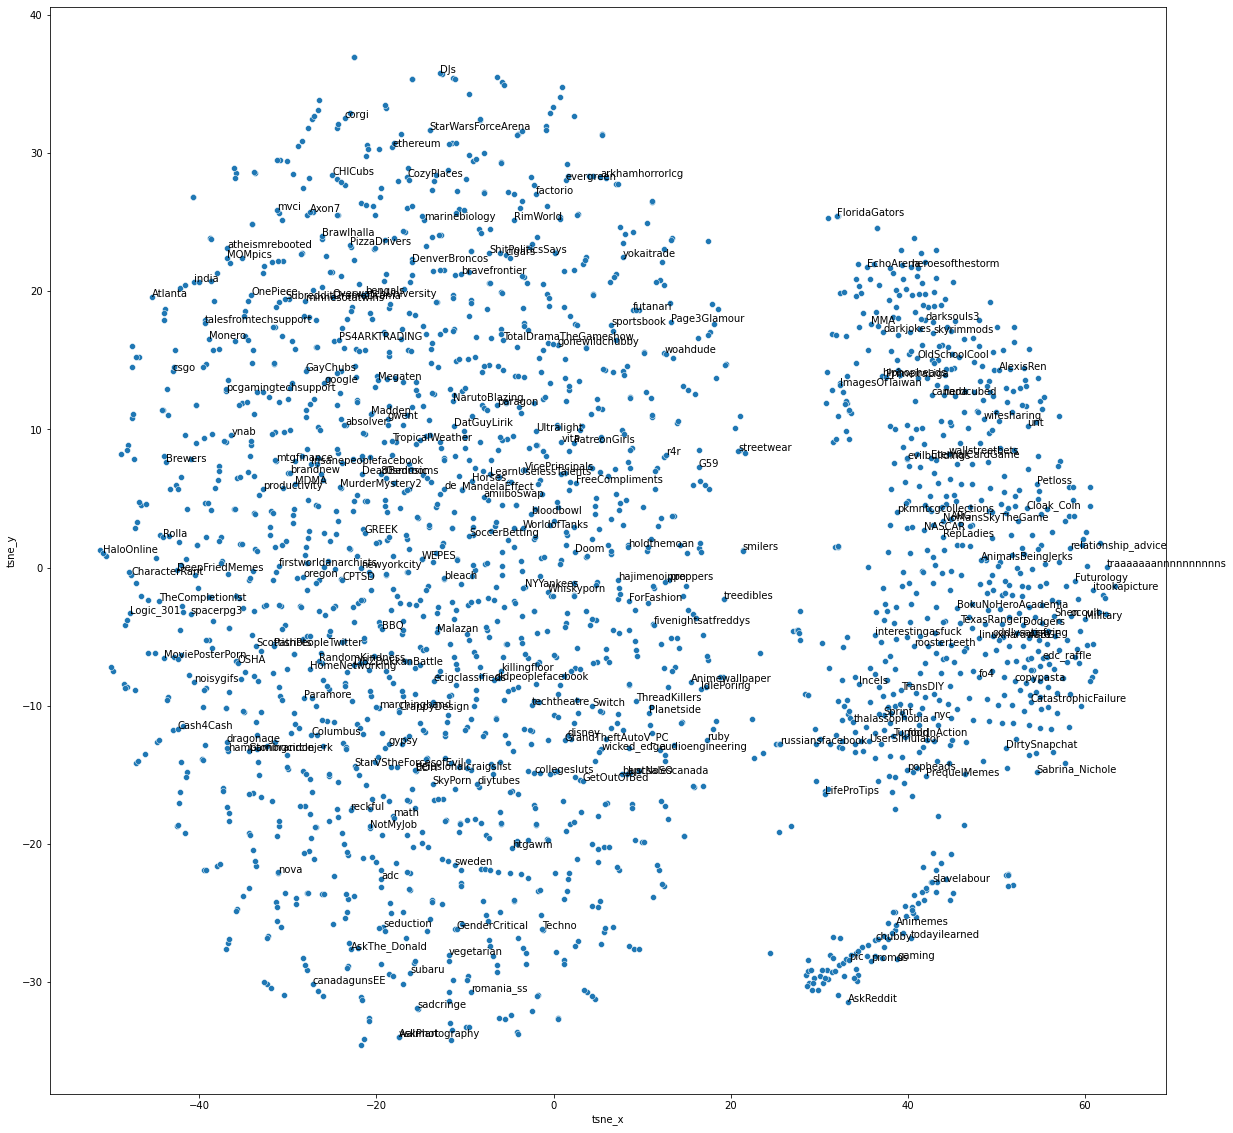

In [ ]:
# Label subset in visualization so it's actually readable
plt.figure(figsize=(20,20))
ax = sns.scatterplot(data=tsne_df, x="tsne_x", y="tsne_y")
for i, subreddit in enumerate(myc2v.get_index_to_key()):
    if i%10==0:
        ax.text(tsne_proj[i][0], tsne_proj[i][1], subreddit)

In [ ]:
fig = px.scatter(tsne_df, x="tsne_x", y="tsne_y", text="subreddit", hover_data=["subreddit"])
fig.show()

# Clustering & Comparing Types of Clustering
This demonstrates some types of clustering on subreddits community embeddings scores. 
Unsupervised clustering is difficult to evaluate since there aren't gold standard labels, however we can look at the overlap and dispersion of clusters using:
 - [Silhouette Coefficient](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient): Ranges between -1 (clustering is totally incorrect) and 1 (clusters are dense and well separated), scores around 0 indicate overlapping clusters.
 - [Calinski-Harabasz Index](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index): Higher for models with clusters that are dense and well separated

In [ ]:
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
import numpy as np

vocab_list = myc2v.get_index_to_key()
embeddings = myc2v.get_normed_vectors()

def compute_and_print_metrics(clustering_model, embeddings):
    labels = clustering_model.labels_
    if len(set(labels)) > 1:
        silhouette = metrics.silhouette_score(embeddings, labels, metric="cosine")
        print("Silhouette:", silhouette)
        ch_index = metrics.calinski_harabasz_score(embeddings, labels)
        print("Calinski-Harabasz Index:", ch_index)
        return silhouette, ch_index
    else:
        print("One clustering found")
        return None, None

def cluster_results_as_df(cluster_labels, vocab_elements, tsne_df, cluster_col_name, vocab_col_name="subreddit"):
    """Return pandas dataframe with both tsne values and cluster labels
    :param cluster_labels: list, cluster assignment for each indexed vocab element
    :param vocab_elements: list, indexed vocab elements, same order and length as cluster labels
    :param tsne_df: pandas DataFrame, tsne coordinates (or other )
    :param cluter_col_name: str, how to name the cluster label column in the dataframe
    :param vocab_col_name: str, name of column for vocab elements to join on with tsne_df
    """
    cluster_df = pd.DataFrame({vocab_col_name: vocab_elements, cluster_col_name:cluster_labels})
    cluster_df[cluster_col_name] = cluster_df[cluster_col_name].astype('category')
    cluster_df = pd.merge(cluster_df, tsne_df, how="inner", on="subreddit", sort=False)
    return cluster_df


## KMeans Clustering

In [ ]:
kmeans_model = KMeans(n_clusters=250, random_state=100)
kmeans_clusters = kmeans_model.fit_predict(embeddings)

In [ ]:
kmeans_df = cluster_results_as_df(kmeans_clusters, vocab_list, tsne_df, 'kmeans_cluster')
kmeans_df.head()

,subreddit,kmeans_cluster,tsne_x,tsne_y
0,AskReddit,0,33.203072,-31.486910
1,CFB,17,31.964781,25.468285
2,CrazyIdeas,165,41.585407,16.098528
3,news,165,51.894226,-22.969233
4,ConciseIAmA,165,34.976772,18.432047


In [ ]:
fig = px.scatter(kmeans_df, x="tsne_x", y="tsne_y", color="kmeans_cluster", hover_data=["subreddit", "kmeans_cluster"])
fig.show()

In [ ]:
compute_and_print_metrics(kmeans_model, embeddings)

Silhouette: 0.2297865
Calinski-Harabasz Index: 5.817382565349361


(0.2297865, 5.817382565349361)

## Affinity Propagation


In [ ]:
# Get pairwise cosine similarity for all subreddits
precomupted_distances = np.zeros((len(vocab_list),len(vocab_list)))
for i, w in enumerate(vocab_list):
    precomupted_distances[i] = np.array(myc2v.w2v_model.wv.distances(w))


In [ ]:
print(precomupted_distances.shape)
print(np.min(precomupted_distances[:10], axis=0))

(2275, 2275)
[-1.19209290e-07  0.00000000e+00  0.00000000e+00 ...  9.57331419e-01
  9.18253958e-01  1.01297176e+00]


In [ ]:
affinity_prop_model = AffinityPropagation(affinity="precomputed", random_state=2, convergence_iter=100, max_iter=1000)
affinity_prop_clusters = affinity_prop_model.fit_predict(precomupted_distances)

/home/virginia/miniconda3/envs/ihop/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



In [ ]:
affinity_prop_df = cluster_results_as_df(affinity_prop_clusters, vocab_list, tsne_df, 'affinity_prop_cluster')
affinity_prop_df.head()

,subreddit,affinity_prop_cluster,tsne_x,tsne_y
0,AskReddit,-1,33.203072,-31.486910
1,CFB,-1,31.964781,25.468285
2,CrazyIdeas,-1,41.585407,16.098528
3,news,-1,51.894226,-22.969233
4,ConciseIAmA,-1,34.976772,18.432047


In [ ]:
fig = px.scatter(affinity_prop_df, x="tsne_x", y="tsne_y", color="affinity_prop_cluster", hover_data=["subreddit", "affinity_prop_cluster"])
fig.show()

In [ ]:
compute_and_print_metrics(affinity_prop_model, embeddings)

One clustering found


(None, None)

## Agglomerative Clustering

In [ ]:
agglomerative_model = AgglomerativeClustering(n_clusters=250, affinity='cosine', linkage="average")
agglomerative_clusters = agglomerative_model.fit_predict(embeddings)

In [ ]:
agglomerative_df = cluster_results_as_df(agglomerative_clusters, vocab_list, tsne_df, 'agglomerative_cluster')
agglomerative_df.head()

,subreddit,agglomerative_cluster,tsne_x,tsne_y
0,AskReddit,9,33.203072,-31.486910
1,CFB,9,31.964781,25.468285
2,CrazyIdeas,9,41.585407,16.098528
3,news,9,51.894226,-22.969233
4,ConciseIAmA,9,34.976772,18.432047


In [ ]:
fig = px.scatter(agglomerative_df, x="tsne_x", y="tsne_y", color='agglomerative_cluster', hover_data=["subreddit", 'agglomerative_cluster'])
fig.show()

In [ ]:
compute_and_print_metrics(agglomerative_model, embeddings)

Silhouette: 0.2899074
Calinski-Harabasz Index: 5.903917497219628


(0.2899074, 5.903917497219628)